## Changement 5ème version
On va modifier la pipeline d'entréee de data, on va préenregistrer les masques et les lires dans notre iterator

In [1]:
import tensorflow as tf
import random
import os
import csv
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import matplotlib.image as mpimg

In [2]:
!pip install pillow

In [3]:
tf.__version__

'2.2.0-dev20200323'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Compétition Kaggle : Image segmentation pour la production d'acier

# Load to memory

### PATHS and DIRECTORIES

In [5]:
# get local variables
local_path = os.getcwd()
data_path = os.path.join(local_path,'data/')

# data directories
train_dir = os.path.join(data_path,'train_images/')
validation_dir = os.path.join(data_path,'validation_images/')

# csv files 
train_csv = os.path.join(data_path,'train.csv')
validation_csv = os.path.join(data_path,'validation.csv')

# mask directories
masks_train_dir = os.path.join(data_path,'train_masks/')
masks_validation_dir = os.path.join(data_path,'validation_masks/')

### Fonctions de conversion

On ne garde en mémoire que les dictionnaires contenant à la fois les descriptions des images. Ainsi, on peut charger à tous moments les masques, très gourmands en mémoire. 

In [6]:
from preprocessing import *

In [7]:
# On créer les dictionnaires importants
train_descriptions = CSV_to_descriptions(train_csv)
validation_descriptions = CSV_to_descriptions(validation_csv)

In [8]:
# On ne garde que ce qui nous intéresse
train_names_list = train_descriptions.keys()
validation_names_list = validation_descriptions.keys()

### Example

0cb590f8e
1.0


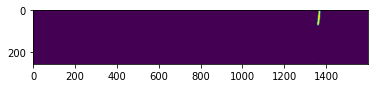

(256, 1600, 3)


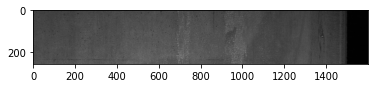

In [28]:
##plot random images with their segmentations

# select random image
img_number = random.randint(0,len(train_descriptions.keys())-1)
img_name = list(train_descriptions.keys())[img_number]
img_name = '0cb590f8e'
print(img_name)
#img = mpimg.imread(os.path.join(TRAINING_DIR,img_name))
#plot image
description_to_image(img_name,train_descriptions,train_dir,True)

# Generator

On commence par une première version simplifiée. On va réduire les data_sets pour réduire le poids en mémoire. De plus on va uniquement programmer en CPU. Les améliorations se succèderont ensuite. 
Images : $256\times1600\times3$


(256, 1600, 4)
1.0


TensorShape([256, 256, 3])

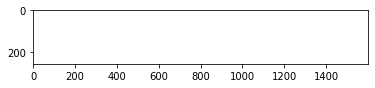

In [10]:
a = mpimg.imread(os.path.join(masks_train_dir,'ef24da2ba'+'.png'))
img_name = 'ef24da2ba'
print(a.shape)
print(a.max())
plt.imshow(a)
img = tf.cast(np.array(mpimg.imread(os.path.join(train_dir,img_name+'.jpg'))),tf.float16)
mask = tf.cast(np.array(mpimg.imread(os.path.join(masks_train_dir,img_name+'.png'))),tf.float16)
img[:,1600-256:1600,:].shape

In [11]:
class generator:
    def __init__(self,descriptions_list,image_directory,masks_directory):
        self.descriptions_list = descriptions_list
        self.image_directory = image_directory
        self.masks_directory = masks_directory
        self.IMG_WIDTH = 256
        self.IMG_LENGTH = 256
        
    def gen_series(self):
        for img_name in self.descriptions_list:
            img = tf.cast(np.array(mpimg.imread(os.path.join(self.image_directory,img_name+'.jpg'))),tf.float16)
            mask = tf.cast(np.array(mpimg.imread(os.path.join(self.masks_directory,img_name+'.png'))),tf.float16)

            for x0 in range(1600//256+1):
                
                if x0 < 1600//256:
                    img2,mask2 = img[:,x0*256:(x0+1)*256,:],mask[:,x0*256:(x0+1)*256,:]
                    img2,mask2 = img2/255.,mask2/255.
                    yield img2,mask2
                else:
                    img2,mask2 = img[:,1600-256:1600,:],mask[:,1600-256:1600,:]
                    img2,mask2 = img2/255.,mask2/255.
                    yield img2,mask2

In [12]:
train_generator = generator(train_names_list,train_dir,masks_train_dir)
validation_generator = generator(validation_names_list,validation_dir,masks_validation_dir)

train_ds = tf.data.Dataset.from_generator(
    train_generator.gen_series,
    output_types = (tf.float16,tf.float16),
    output_shapes = (tf.TensorShape([256,256,3]), tf.TensorShape([256,256,4]))
) 
# attention validation différent de test
validation_ds = tf.data.Dataset.from_generator(
    validation_generator.gen_series,
    output_types = (tf.float16,tf.float16),
    output_shapes = (tf.TensorShape([256,256,3]), tf.TensorShape([256,256,4]))
) 

In [13]:
train_ds = train_ds.batch(16)
validation_ds = validation_ds.batch(16)

In [14]:
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float16, name=None),
 TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float16, name=None))

# Création du modèle

In [16]:
# import all layers
from tensorflow.keras.layers import *

In [17]:
def pick(double,tolerance):
    "choose if 1 or 0 tolerance should be 0.5"
    if double > tolerance and double <=1:
        return 1
    elif double >=0 and double <=1:
        return 0
    else :
        print('erreur dans la probabilité, voir loss ')
        
pick_vecteur = np.vectorize(pick,excluded = ['tolerance'])

def dice_coefficient(y_true,y_pred,tolerance = 0.5 ):
    "metric function"
    
    intersection = pick_vecteur(y_true*y_pred,tolerance)
    intersection = 2*np.sum(intersection)
    
    if np.sum(y_true) == 0 and np.sum(y_pred)==0 :
        return 1
    else :
        return intersection/(np.sum(y_pred)+np.sum(y_true))
    
def jaccard_distance(y_true, y_pred, smooth=100):
    "loss function"
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum((y_true * y_pred))
    sum_ = tf.reduce_sum(y_true+y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [18]:
def dice(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

In [19]:
# Focal Tversky loss, brought to you by:  https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

In [20]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = tf.keras.Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    
    #loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_object = focal_tversky_loss
    
    optimizer_object = tf.keras.optimizers.Adam()

    model.compile(optimizer = optimizer_object, loss = loss_object, metrics = [tversky])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [21]:
model = unet()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet.hdf5',monitor = 'loss', verbose =1, save_best_only = True)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [23]:
model.fit(train_ds,epochs =13)

Epoch 1/13
    244/Unknown - 165s 677ms/step - loss: 1.0000 - tversky: 1.1895e-05

KeyboardInterrupt: 

# Post Processing

In [ ]:
def predict(input_image_name,image_directory):
    "predict of an image by its name"
    input_image = mpimg.imread(os.path.join(image_directory,input_image_name+'.jpg'))
    input_image = np.expand_dims(input_image,axis = 0)
    input_image = np.array(input_image,dtype = np.float32)
    
    output_image = np.zeros((1,256,0,4))
    for x0 in range(1600//256):
        
        pred = model.predict(input_image[:,:,x0*256:(x0+1)*256,:])
        
        output_image = np.concatenate((output_image,pred),axis =2)
    
    pred = model.predict(input_image[:,:,1600-256:1600,:])
    
    output_image = np.concatenate((output_image,pred[:,:,256-1600%256:256,:]), axis =2)
    
    return output_image
    

In [ ]:
pred = predict('ef24da2ba',train_dir)


In [ ]:
def verif(input_image_name,image_directory,dict_descriptions):
    "Des verifications permettant de verifier ce que fait le predict"
    
    prediction_image = predict(input_image_name,image_directory)
    reality_image =np.expand_dims(image_to_mask_4(dict_descriptions,input_image_name),axis = 0)
    print(prediction_image.shape,reality_image.shape)
    print("somme de la prediction" ,np.sum(prediction_image))
    print("somme de la realité", np.sum(reality_image))
    print("difference des deux", np.sum(reality_image-prediction_image))
    
    #rajouter ensuite pour chaque défaut
    

In [ ]:
verif('ef24da2ba',train_dir,train_descriptions)


In [ ]:
# we will predict this image

image_directory = join(os.getcwd(),'data','train_images/')
input_image_name = 'ef24da2ba'

input_image = mpimg.imread(os.path.join(image_directory,input_image_name+'.jpg'))
input_image = np.expand_dims(input_image,axis = 0)
input_image = np.array(input_image,dtype = np.float32)
input_image = input_image[:,:,0:256,:]
pred = model.predict(input_image)

pred.shape